## DDPM Code in 100 Lines

In [1]:
import numpy as np
import copy
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from diffusers.models.unet_2d import UNet2DModel as Unet
from diffusers import DDPMScheduler
from tqdm import tqdm
from IPython import display

/home/gaudio/anaconda3/envs/lsd/lib/python3.8/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


### Dataset

In [2]:
transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                               ])
# MNIST Dataset
train_data = datasets.MNIST('mnist_data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16)
print(train_loader)

### Model Initialization

In [4]:
step = 0
# Unet Model
model = Unet(sample_size=32,
            in_channels=1,
            out_channels=1,
            center_input_sample=False,
            time_embedding_type="positional",
            down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D", "AttnDownBlock2D"),
            up_block_types=("AttnUpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D"),
            block_out_channels=(64, 128, 256, 512),
            layers_per_block=3).cuda()
# EMA Model
ema_model = copy.deepcopy(model)
ema_model = ema_model.cuda()
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# Diffusion Scheduler
scheduler = DDPMScheduler(num_train_timesteps=1000)
print('Model initialized.')

Model initialized.


In [5]:
model

UNet2DModel(
  (conv_in): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): LoRACompatibleLinear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): LoRACompatibleLinear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-2): 3 x ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): LoRACompatibleConv(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): LoRACompatibleLinear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): LoRACompatibleConv(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleLis

### Train & Inference

100%|████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 52.39it/s]


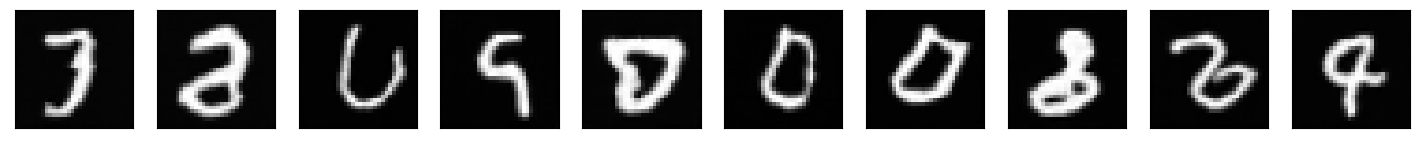

In [6]:
while True:
    for batch in train_loader:
        # Data Preparation
        x, _ = batch
        x = x * 2 - 1
        x = x.cuda()
        z = torch.randn_like(x)
        t = torch.randint(0, len(scheduler.betas), size=(len(x),)).cuda()
        x_noisy = scheduler.add_noise(x, z, t) 
        # Model Forward
        model.train()
        model.zero_grad()
        z_pred = model(x_noisy, t)['sample']
        loss = F.mse_loss(z_pred, z)  
        # Model Backward
        loss.backward()
        optimizer.step()
        # EMA Model Update
        model_state_dict = model.state_dict()
        ema_model_state_dict = ema_model.state_dict()
        for key in model_state_dict:
            ema_model_state_dict[key] = 0.999*ema_model_state_dict[key] + 0.001*model_state_dict[key]
        ema_model.load_state_dict(ema_model_state_dict)
        
        if step % 10 == 0:
            print('step :', step, 'loss :', loss.item())
        if step % 100 == 0:
            display.clear_output() 
        if step % 1000 == 0: 
            # Sampling    
            ema_model.eval()
            with torch.no_grad():
                x = torch.randn(10, 1, 32, 32).cuda()
                for t in tqdm(range(len(scheduler.betas)-1, -1, -1)):
                    t_tensor = torch.ones((len(x),)).cuda() * t
                    z_pred = ema_model(x, t_tensor)['sample']
                    x = scheduler.step(z_pred, t, x)['prev_sample']
               
            # Show Samples
            import matplotlib.pyplot as plt
            plt.figure(figsize=[18, 3])
            for i in range(10):
                plt.subplot(1, 10, i+1)
                plt.imshow(x[i, 0].data.cpu().numpy(), cmap='gray')
                plt.xticks([])
                plt.yticks([])
            plt.show()
                
        step += 1
        if step > 5000:
            break
            
    if step > 5000:        
        break

### Adding Noise and De-nosing

Adding Noise

$
\mathbf{x}_{t}\left(\mathbf{x}_{0}, \boldsymbol{\epsilon}\right)=\sqrt{\bar{\alpha}_{t}} \mathbf{x}_{0}+\sqrt{1-\bar{\alpha}_{t}} \boldsymbol{\epsilon}
$

De-noising
$
\mathbf{x}_{0} = 
{
{\mathbf{x}_{t} - \sqrt{1 - \bar \alpha_t} \epsilon_\theta(\mathbf{x}_t, t)}
\over
{\sqrt{\bar \alpha_t}}
}
$

x_t : Noisy Samples


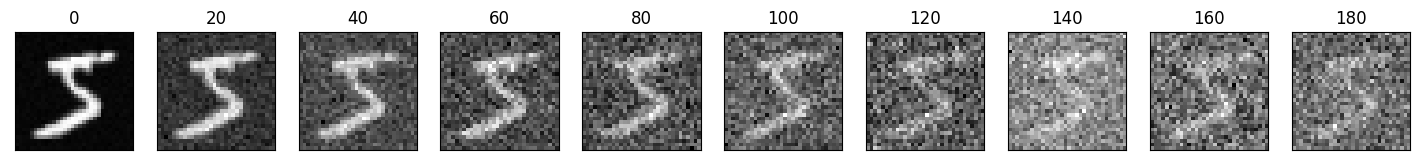

z : Predicted Noise


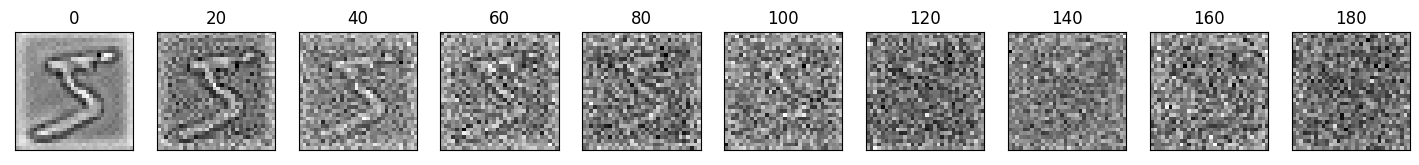

x_0 : De-noised Samples


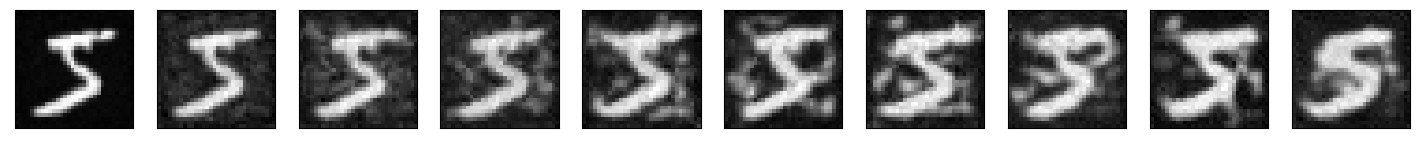

In [36]:
# (b, c, h, w)
x, _ = next(iter(train_loader))
# (10, c, h, w)
x = torch.cat([x[0:1] for _ in range(10)], dim=0).cuda()
# (10, c, h, w)
z = torch.randn_like(x)
# (10,)
t_tensor = torch.from_numpy(np.array([i for i in range(0, 200, 20)])).cuda()
# (10, c, h, w)
x_noisy = scheduler.add_noise(x, z, t_tensor) 

ema_model.eval()
with torch.no_grad():
    # (10, c, h, w)
    z_pred = ema_model(x_noisy, t_tensor)['sample']
    # (10, 1, 1, 1)
    alphas_cumprod = scheduler.alphas_cumprod.to(t_tensor.device)[t_tensor][:, None, None, None]
    # (10, 1, 1, 1)
    one_minus_alphas_cumprod = 1 - alphas_cumprod
    # https://github.com/huggingface/diffusers/blob/v0.29.2/src/diffusers/schedulers/scheduling_ddpm.py#L449
    # (10, c, h, w)
    x0_pred = (x_noisy - one_minus_alphas_cumprod ** (0.5) * z_pred) / alphas_cumprod ** (0.5)
    
import matplotlib.pyplot as plt

print('x_t : Noisy Samples')
plt.figure(figsize=[18, 3])
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.title(t_tensor[i].data.cpu().numpy())
    plt.imshow(x_noisy[i, 0].data.cpu().numpy(), cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.show()    

print('z : Predicted Noise')
plt.figure(figsize=[18, 3])
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.title(t_tensor[i].data.cpu().numpy())
    plt.imshow(z_pred[i, 0].data.cpu().numpy(), cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.show()    

print('x_0 : De-noised Samples')
plt.figure(figsize=[18, 3])
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(x0_pred[i, 0].data.cpu().numpy(), cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.show()    
